This notebook introduces how to use EPCOT to predict epigenomic features, CAGE-seq, chromatin contact maps, and enhancer activity, and provides examples of cross cell/tissue prediction which are presented in the paper.

If you use our codes in your research, please cite:

Zhang, Z., Qiu, Y., Feng, F., & Liu, J. (2022). A generalizable framework to comprehensively predict epigenome, chromatin organization, and transcriptome. bioRxiv. https://doi.org/10.1101/2022.05.23.493129.

Please open Google Colab notebook under GPU setting : **Runtime -> Change runtime type -> select GPU**

 **Install packages**

In [ ]:
!pip install kipoiseq==0.5.2 --quiet > /dev/null
!pip install einops
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Download EPCOT source code**

In [ ]:
### clone our GitHub repo
!git clone https://github.com/liu-bioinfo-lab/EPCOT.git
!mkdir models

Cloning into 'EPCOT'...
remote: Enumerating objects: 1181, done.
remote: Counting objects: 100% (387/387), done.
remote: Compressing objects: 100% (206/206), done.
remote: Total 1181 (delta 227), reused 307 (delta 178), pack-reused 794
Receiving objects: 100% (1181/1181), 74.71 MiB | 13.93 MiB/s, done.
Resolving deltas: 100% (268/268), done.


**Import packages**

In [ ]:
import kipoiseq
from kipoiseq import Interval
import pyfaidx
import pandas as pd
import numpy as np
from scipy.sparse import load_npz
import torch
import argparse
import sys,os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
sys.path.append('EPCOT/')
from usage_util import *
from pretraining.model import build_model
sys.path.append('EPCOT/GEP/')
from cage.model import build_pretrain_model_cage
sys.path.append('EPCOT/COP/')
from hic.model import build_pretrain_model_hic
from microc.model import build_pretrain_model_microc

**Download and index reference genome file**

In [ ]:
### The following codes are copied from https://github.com/deepmind/deepmind-research/blob/master/enformer/enformer-usage.ipynb
fasta_file = '/root/data/genome.fa'
!mkdir -p /root/data
!wget -O - http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz | gunzip -c > {fasta_file}
pyfaidx.Faidx(fasta_file)
!ls /root/data
class FastaStringExtractor:
    def __init__(self, fasta_file):
        self.fasta = pyfaidx.Fasta(fasta_file)
        self._chromosome_sizes = {k: len(v) for k, v in self.fasta.items()}

    def extract(self, interval: Interval, **kwargs) -> str:
        # Truncate interval if it extends beyond the chromosome lengths.
        chromosome_length = self._chromosome_sizes[interval.chrom]
        trimmed_interval = Interval(interval.chrom,
                                    max(interval.start, 0),
                                    min(interval.end, chromosome_length),
                                    )
        # pyfaidx wants a 1-based interval
        sequence = str(self.fasta.get_seq(trimmed_interval.chrom,
                                          trimmed_interval.start + 1,
                                          trimmed_interval.stop).seq).upper()
        # Fill truncated values with N's.
        pad_upstream = 'N' * max(-interval.start, 0)
        pad_downstream = 'N' * max(interval.end - chromosome_length, 0)
        return pad_upstream + sequence + pad_downstream

    def close(self):
        return self.fasta.close()
fasta_extractor = FastaStringExtractor(fasta_file)

--2022-06-28 01:52:17--  http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz
Resolving hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 983659424 (938M) [application/x-gzip]
Saving to: ‘STDOUT’

-                   100%[===================>] 938.09M  9.61MB/s    in 75s     

2022-06-28 01:53:32 (12.5 MB/s) - written to stdout [983659424/983659424]

genome.fa  genome.fa.fai


**Download example input DNase-seq tracks and EPCOT trained models**

In [ ]:
### The DNase-seq tracks are saved as python dictionary structure where the keys are chromosomes and values are sparse matrix of DNase-seq.
!gdown 1poU4h4Uf6jMfc4ICTy6-wIRdPGjoCMHE --output GM12878_dnase.pickle
!gdown 1MWZEktc6OjX2staP2YDtYafFnWHv5afm --output stomach_f53_dnase.pickle
!gdown 1g4QEEppXxMohrrmsQdcXGBejznZIZaVA --output hff_dnase.pickle
!gdown 1XEvDzsLPN6cmJPcV5y4XS1DQmLqOZ1aR --output tibial_nerve_m37_dnase.pickle
!gdown 1oYTU35UmyO7G-i_ulNW3uCELJaKkElhQ --output transverse_colon_m37_dnase.pickle

### download example DNase-seq in chromosome 11
HCT116_dnase=load_npz('EPCOT/examples/HCT116_dnase_chr11.npz').toarray().squeeze()
HUVEC_dnase=load_npz('EPCOT/examples/HUVEC_dnase_chr11.npz').toarray().squeeze()
IMR90_dnase=load_npz('EPCOT/examples/IMR-90_dnase_chr11.npz').toarray().squeeze()
HepG2_dnase=load_npz('EPCOT/examples/HepG2_dnase_chr11.npz').toarray().squeeze()

Downloading...
From: https://drive.google.com/uc?id=1poU4h4Uf6jMfc4ICTy6-wIRdPGjoCMHE
To: /content/GM12878_dnase.pickle
100% 408M/408M [00:01<00:00, 359MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MWZEktc6OjX2staP2YDtYafFnWHv5afm
To: /content/stomach_f53_dnase.pickle
100% 893M/893M [00:03<00:00, 252MB/s]
Downloading...
From: https://drive.google.com/uc?id=1g4QEEppXxMohrrmsQdcXGBejznZIZaVA
To: /content/hff_dnase.pickle
100% 1.48G/1.48G [00:05<00:00, 275MB/s]
Downloading...
From: https://drive.google.com/uc?id=1XEvDzsLPN6cmJPcV5y4XS1DQmLqOZ1aR
To: /content/tibial_nerve_m37_dnase.pickle
100% 824M/824M [00:08<00:00, 102MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1oYTU35UmyO7G-i_ulNW3uCELJaKkElhQ
To: /content/transverse_colon_m37_dnase.pickle
100% 755M/755M [00:02<00:00, 264MB/s]


In [ ]:
### pre-training model
!gdown 1_YfpNSv-2ABQV2qSyBxem-y7aJFyRNzz --output models/pretrain_dnase.pt
### pre-training models trained on ATAC-seq 
# !gdown 1aMb3kVmaWZPUzqKmfZs9xWT-QLUGjQQd --output models/pretrain_atac.pt
### CAGE-seq GEP
!gdown 1eP-ruOcywlGeQIRuVwWk_QFc4z9j4-jF --output models/cage_transformer.pt

### Hi-C COP
### Models trained on different cell/tissue types
!gdown 1EXm2AjqqO-UtLi2pprbDEb1gPXrxI3aW --output models/hic_GM12878_transformer.pt
!gdown 1ia-ZoSoiZGDFPnZcySzMpirovHhulRfH --output models/hic_HFF_transformer.pt
!gdown 1ofkpS526gXpnusGpRWVHgIFFFpTSW4Rm --output models/hic_IMR-90_transformer.pt
!gdown 1OtWkTLuYad3iRPuGy5OCewNGPlr47ogA --output models/hic_trans_colon_m37_transformer.pt
### models trained on ATAC-seq
# !gdown 1Lyfpn9YOscMbYCp79F3BDrlOSX77Q_P_ --output models/GM12878_hic_atac.pt
# !gdown 1L6Woz9gqZa_bkuZFJj3FzJ41RW79zSav --output trans_colon_m37_hic_atac.pt
### CTCF ChIA-PET
!gdown 1DW1K8L3EXfbliyxJ0hgKSLamy_w0YNEC --output models/GM12878_CTCF_chiapet.pt
### Micro-C COP
!gdown 1D8ue_YiljdNqcpIM5xIcJ7fUfREczbEq --output models/HFF_microc.pt

Downloading...
From: https://drive.google.com/uc?id=1_YfpNSv-2ABQV2qSyBxem-y7aJFyRNzz
To: /content/models/pretrain_dnase.pt
100% 100M/100M [00:00<00:00, 339MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1eP-ruOcywlGeQIRuVwWk_QFc4z9j4-jF
To: /content/models/cage_transformer.pt
100% 119M/119M [00:02<00:00, 57.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1EXm2AjqqO-UtLi2pprbDEb1gPXrxI3aW
To: /content/models/hic_GM12878_transformer.pt
100% 119M/119M [00:02<00:00, 54.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ia-ZoSoiZGDFPnZcySzMpirovHhulRfH
To: /content/models/hic_HFF_transformer.pt
100% 119M/119M [00:02<00:00, 54.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ofkpS526gXpnusGpRWVHgIFFFpTSW4Rm
To: /content/models/hic_IMR-90_transformer.pt
100% 119M/119M [00:02<00:00, 52.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OtWkTLuYad3iRPuGy5OCewNGPlr47ogA
To: /content/models/hic_trans_colon_m37_transformer.pt
100% 119M/119M [00:0

**Specify device and model arguments**

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# model parameters 
args,parser = get_args()
cage_args=parser_args_cage(parser)
hic_args=parser_args_hic(parser)
microc_args=parser_args_microc(parser)

cuda:0


## Epigenomic feature, gene expression, and contact map prediction using EPCOT

This section demonstrates how to use EPCOT to predict multiple modalities, including
* task1: Epigenomic feature prediction (EFP)
* task2: CAGE-seq gene expression prediction (GEP)
* task3: 5kb-resolution Hi-C (ChIA-PET) contact map prediction (COP)
* task4: 1kb-resolution Micro-C contact map prediction

**Steps:**
1. **Load input DNase-seq**. The inputs to EPCOT are RPGC normalized DNase-seq or ATAC-seq. For how to generate the input DNase-seq, please see [our GitHub repo](https://github.com/liu-bioinfo-lab/EPCOT/tree/main/Data).

2. **Load trained models**.

3. **Specify input arguments of each prediction function**. Functions ```predict_epis```, ```predict_cage```, ```predict_hic```, and ```predict_microc``` predict epigenomic features, CAGE-seq, Hi-C (ChIA-PET), and Micro-C, respectively, which have following arguments:
* ```model``` specifies the model to predict each of the modalities
* ```chrom```, ```start```, ```end```  sepecify chromosome, start position, end position of the input genomic region
* ```dnase``` : DNase-seq of cell type of interest. You can input your own DNase-seq  to make predictions.

4. **Make predictions and visualize prediction results**.

Please see below for how to predict each of the tasks in GM12878 cell line

**Load input DNase-seq of GM12878**

In [ ]:
input_dnase_file='GM12878_dnase.pickle'
import pickle
with open(input_dnase_file,'rb') as f:
    tmp_GM12878_dnase=pickle.load(f)

**Task1: Epigenomic feature prediction (EFP)**

In [ ]:
### load pre-training model
pretrain_model= build_model(args)
pretrain_model.to(device)
pretrain_model.eval()
pretrain_model.load_state_dict(torch.load('models/pretrain_dnase.pt'))

<All keys matched successfully>

In [ ]:
### enter region of interest ('end-start' should be divisble by 1000)
chrom,start,end=['chr11',46750000,47750000]
GM12878_input_dnase=tmp_GM12878_dnase[chrom[3:]].toarray().squeeze()

### output the predict scores of 245 epigenomic features on each 1kb bin of the input genomic region
pred_score_epi=predict_epis(model=pretrain_model,
                            chrom=chrom, start=start,end=end,
                            dnase=GM12878_input_dnase,
                            fasta_extractor=fasta_extractor)
pred_score_epi.shape

(1000, 245)

In [ ]:
### a list of epigenomic features predicted by EPCOT
with open('EPCOT/Profiles/epigenomes.txt', 'r') as f:
    epigenomes = f.read().splitlines()
!head -3 EPCOT/Profiles/epigenomes.txt

CTCF
RAD21
ATF7


Visualize results

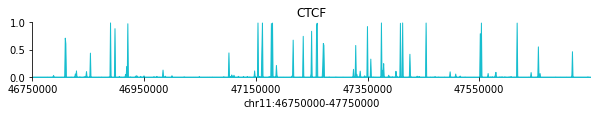

In [ ]:
### choose the index of epigenome feature of interest from the list of predicted epigenomic features 
epi_idx=0

### plot results
fig,ax=plt.subplots(figsize=(10,1))
val=pred_score_epi[:,0]
plot_bindings(ax,val, chrom,start,end)
ax.set_title(epigenomes[epi_idx])
ax.set_xlabel('%s:%s-%s'%(chrom,start,end))
plt.show()

**Task2: CAGE-seq gene expression prediction (GEP)**
* The downstream model to predict 1kb-resolution CAGE-seq takes the input of 250kb genomic regions and predicts the CAGE-seq in the centered 200kb region.

In [ ]:
cage_model= build_pretrain_model_cage(cage_args)
cage_model.to(device)
cage_model.eval()
### load trained model
cage_model.load_state_dict(torch.load('models/cage_transformer.pt'))

<All keys matched successfully>

In [ ]:
### enter region of interest ('cage_end-cage_start' should be divisible by 200000)
cage_chrom,cage_start,cage_end=['chr11',46750000,47750000]
GM12878_input_dnase=tmp_GM12878_dnase[chrom[3:]].toarray().squeeze()

### output predicted 1kb-resolution CAGE-seq in this region
pred_cage=predict_cage(model=cage_model,
                       chrom=cage_chrom,start=cage_start,end=cage_end,
                       dnase=GM12878_input_dnase,
                       fasta_extractor=fasta_extractor)
pred_cage.shape

(1000,)

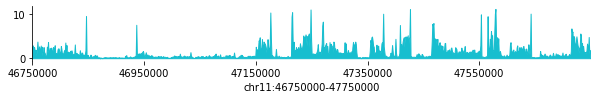

In [ ]:
### plot results
fig,ax=plt.subplots(figsize=(10,1))
plot_cage(ax,pred_cage,cage_chrom,cage_start,cage_end)

**Task3: Hi-C and ChIA-PET contact map prediction (COP)**
* The downstream model in these two tasks has the same model archietcture.
* EPCOT predicts the upper triangular of contact matrices in the centered 960kb region of the input 1Mb region

In [ ]:
### arguments for hic downstream model
hic_model= build_pretrain_model_hic(hic_args)
hic_model.cuda()
hic_model.eval()
for m in hic_model.modules():
    if m.__class__.__name__.startswith('BatchNorm'):
        m.train()
### load GM12878 model
hic_model.load_state_dict(torch.load('models/hic_GM12878_transformer.pt'))

61


<All keys matched successfully>

In [ ]:
### regions of interest (input a 1Mb region where 'hic_end-hic_start' should be equal 1000000)
hic_chrom,hic_start,hic_end=['chr11',46750000,47750000]

GM12878_input_dnase=tmp_GM12878_dnase[hic_chrom[3:]].toarray().squeeze()

### the output is an array of the upper triangular of the contact matrix
pred_hic=predict_hic(
    model=hic_model,
    chrom=hic_chrom,start=hic_start,end=hic_end,
    dnase=GM12878_input_dnase,
    fasta_extractor=fasta_extractor)
### convert the upper triangular array into a contact matrix
pred_hic_mat=complete_mat(arraytouptri(pred_hic.squeeze(),hic_args))
pred_hic_mat.shape

(192, 192)

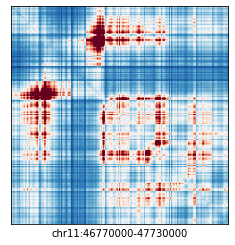

In [ ]:
### plot results
fig,ax=plt.subplots()
plot_hic(ax,pred_hic_mat,vmin=0,vmax=5)
ax.set_xlabel('%s:%s-%s'%(hic_chrom,hic_start+20000,hic_end-20000))
plt.show()

In [ ]:
chiapet_model= build_pretrain_model_hic(hic_args)
chiapet_model.cuda()
chiapet_model.eval()
for m in chiapet_model.modules():
    if m.__class__.__name__.startswith('BatchNorm'):
        m.train()
chiapet_model.load_state_dict(torch.load('models/GM12878_CTCF_chiapet.pt'))

61


<All keys matched successfully>

In [ ]:
### regions of interest, please input a 1Mb region (end-start=1000000)
hic_chrom,hic_start,hic_end=['chr11',74750000,75750000]
GM12878_input_dnase=tmp_GM12878_dnase[hic_chrom[3:]].toarray().squeeze()

pred_hic=predict_hic(
    model=chiapet_model,
    chrom=hic_chrom,start=hic_start,end=hic_end,
    dnase=GM12878_input_dnase,
    fasta_extractor=fasta_extractor)
pred_hic_mat=complete_mat(arraytouptri(pred_hic.squeeze(),hic_args))

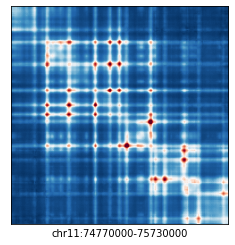

In [ ]:
#plot results
fig,ax=plt.subplots()
plot_hic(ax,pred_hic_mat,vmin=0,vmax=3)
ax.set_xlabel('%s:%s-%s'%(hic_chrom,hic_start+20000,hic_end-20000))
plt.show()

**Task4: Micro-C contact map prediction**
* EPCOT predicts the upper triangular of 1kb-reolsution Micro-C contact matrices in the centered 500kb region of the input 600kb region

In [ ]:
# load DNase-seq of HFF
import pickle
with open('hff_dnase.pickle','rb') as f:
    hff_tmp_dnase=pickle.load(f)

In [ ]:
microc_model= build_pretrain_model_microc(microc_args)
microc_model.cuda()
microc_model.eval()
for m in microc_model.modules():
    if m.__class__.__name__.startswith('BatchNorm'):
        m.train()
microc_model.load_state_dict(torch.load('models/HFF_microc.pt'))

61


<All keys matched successfully>

Text(0.5, 0, 'chr11:113050000-113550000')

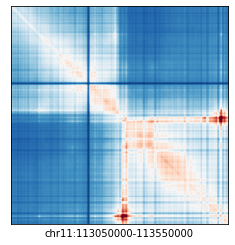

In [ ]:
### regions of interest, please input a 600kb region (end-start=600000)
microc_chrom,microc_start,microc_end=['chr11',113000000,113600000]
hff_input_dnase=hff_tmp_dnase[hic_chrom[3:]].toarray().squeeze()
pred_microc=predict_microc(model=microc_model,
                           chrom=microc_chrom,start=microc_start,end=microc_end,
                           dnase=hff_input_dnase,
                           fasta_extractor=fasta_extractor)
pred_microc=complete_mat(arraytouptri(pred_microc.squeeze(),microc_args))
fig,ax=plt.subplots()
plot_hic(ax,pred_microc,vmin=-2,vmax=2)
ax.set_xlabel('%s:%s-%s'%(microc_chrom,microc_start+50000,microc_end-50000))

## Examples of cross-cell/tissue type prediction
This section provides some detailed examples of predicting modalities in new cell/tissue types, which are presented in the paper, including 

* Cross-cell type prediction in HUVEC and HCT116

* Cross-tissue type prediction in GTEx tissue dononrs

* Cross-cell type ChIA-PET prediction 

* Cross-cell/tissue type Micro-C prediction 

If the input DNase-seq has different distribution to our training DNase-seq, it may be helpful to add 

```
for m in model.modules():
    if m.__class__.__name__.startswith('BatchNorm'):
        m.train()
```
after ```model.eval()``` in COP tasks, which uses batch statistics instead of running statistics in batch normalization for inference.

**Example 1: cross-cell type prediction in HCT116 and HUVEC**

<!-- For cross-cell type prediction, it is important that the normalized DNase-seq in training cell types and testing cell types have similar data scales, if not, maybe some normalization methods are needed. -->

In [ ]:
pretrain_model= build_model(args)
pretrain_model.to(device)
pretrain_model.eval()
### load pre-training model
pretrain_model.load_state_dict(torch.load('models/pretrain_dnase.pt'))

cage_model= build_pretrain_model_cage(cage_args)
cage_model.to(device)
cage_model.eval()
cage_model.load_state_dict(torch.load('models/cage_transformer.pt'))

###  Hi-C cross-cell type predicition
###  load models trained on GM12878 and IMR-90
hic_model_gm= build_pretrain_model_hic(hic_args)
hic_model_gm.cuda()
hic_model_gm.eval()
hic_model_gm.load_state_dict(torch.load('models/hic_GM12878_transformer.pt'))
hic_model_imr= build_pretrain_model_hic(hic_args)
hic_model_imr.cuda()
hic_model_imr.eval()
hic_model_imr.load_state_dict(torch.load('models/hic_IMR-90_transformer.pt'))

61
61


<All keys matched successfully>

In [ ]:
###  cross-cell type epigenomic feature prediction
###  region of interest
chrom,start,end=['chr11',86770000,87730000]
pred_epi= predict_epis(model=pretrain_model,
                       chrom=chrom,start=start,end=end,
                       dnase=HCT116_dnase,
                       fasta_extractor=fasta_extractor)

###  Cross-cell type CAGE-seq prediction
cage_chrom,cage_start,cage_end=['chr11',86750000,87750000]
pred_cage= predict_cage(model=cage_model,
                        chrom=cage_chrom,start=cage_start,end=cage_end,
                        dnase=HCT116_dnase,
                        fasta_extractor=fasta_extractor)

###  cross-cell type contact map prediction 
hic_chrom,hic_start,hic_end=['chr11',86750000,87750000]
pred_hic1=predict_hic(model=hic_model_gm,
                      chrom=hic_chrom,start=hic_start,end=hic_end,
                      dnase=HCT116_dnase,
                      fasta_extractor=fasta_extractor)
pred_hic2=predict_hic(hic_model_imr,hic_chrom,hic_start,hic_end,HCT116_dnase,fasta_extractor)

### using ensemble of models trained on GM12878 and IMR-90
pred_hic=(pred_hic1+pred_hic2)/2
pred_hic_mat=complete_mat(arraytouptri(pred_hic.squeeze(),hic_args))

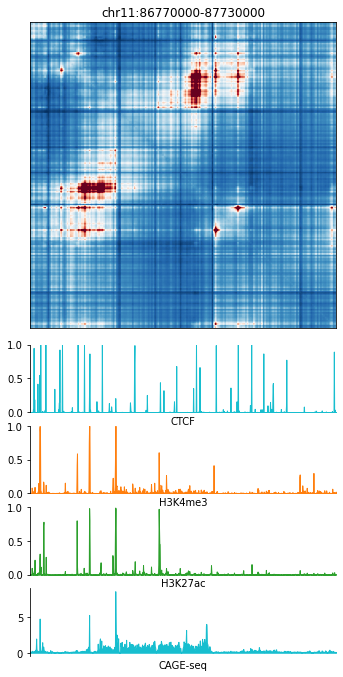

In [ ]:
###  plot results
fig = plt.figure(figsize=(5, 9.5))
gs = GridSpec(8, 5, wspace = 0.75, hspace = 0.2, left = 0.05, top = 0.98, right = 0.9, bottom = 0.05)
ax_hic = fig.add_subplot(gs[:4, :5])
ax_track= [fig.add_subplot(gs[4+i:5+i,:5]) for i in range(4)]
plot_hic(ax_hic,pred_hic_mat,vmin=0,vmax=4)
epis=['CTCF','H3K4me3','H3K27ac','CAGE-seq']
plot_bindings(ax_track[0],pred_epi[:,0], chrom,start,end)
plot_bindings(ax_track[1],pred_epi[:,-3], chrom,start,end,color='tab:orange')
plot_bindings(ax_track[2],pred_epi[:,-6], chrom,start,end,color='tab:green')
plot_cage(ax_track[3],pred_cage[20:-20],cage_chrom,cage_start,cage_end)
for i in range(len(ax_track)):
  ax_track[i].set_xticks([])
  ax_track[i].set_xlabel(epis[i])
ax_hic.set_title('%s:%s-%s'%(chrom,start,end))
plt.show()

In [ ]:
###  cross-cell type contact map prediction using ensemble of models trained on GM12878 and IMR-90
hic_chrom,hic_start,hic_end=['chr11',86750000,87750000]
pred_hic1=predict_hic(model=hic_model_gm,
                      chrom=hic_chrom,start=hic_start,end=hic_end,
                      dnase=HUVEC_dnase,
                      fasta_extractor=fasta_extractor)
pred_hic2=predict_hic(hic_model_imr,hic_chrom,hic_start,hic_end,HUVEC_dnase,fasta_extractor)
pred_hic=(pred_hic1+pred_hic2)/2
pred_hic_mat=complete_mat(arraytouptri(pred_hic.squeeze(),hic_args))

###  cross-cell type epigenomic feature prediction
###  region of interest
chrom,start,end=['chr11',86770000,87730000]
pred_epi= predict_epis(model=pretrain_model,
                       chrom=chrom,start=start,end=end,
                       dnase=HUVEC_dnase,
                       fasta_extractor=fasta_extractor)

###  Cross-cell type CAGE-seq prediction
cage_chrom,cage_start,cage_end=['chr11',86750000,87750000]
pred_cage= predict_cage(model=cage_model,
                        chrom=cage_chrom,start=cage_start,end=cage_end,
                        dnase=HUVEC_dnase,
                        fasta_extractor=fasta_extractor)

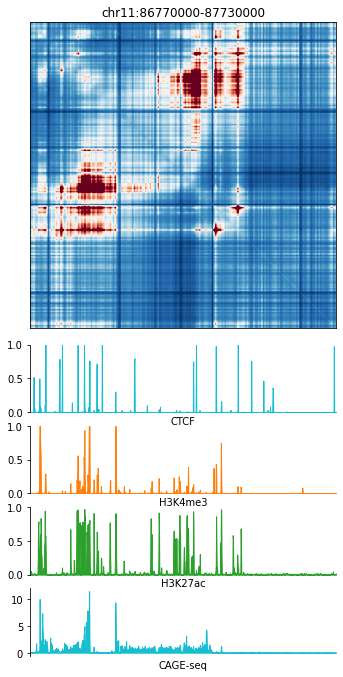

In [ ]:
###  plot results
fig = plt.figure(figsize=(5, 9.5))
gs = GridSpec(8, 5, wspace = 0.75, hspace = 0.2, left = 0.05, top = 0.98, right = 0.9, bottom = 0.05)
ax_hic = fig.add_subplot(gs[:4, :5])
ax_track= [fig.add_subplot(gs[4+i:5+i,:5]) for i in range(4)]
plot_hic(ax_hic,pred_hic_mat,vmin=0,vmax=4)
epis=['CTCF','H3K4me3','H3K27ac','CAGE-seq']
plot_bindings(ax_track[0],pred_epi[:,0], chrom,start,end)
plot_bindings(ax_track[1],pred_epi[:,-3], chrom,start,end,color='tab:orange')
plot_bindings(ax_track[2],pred_epi[:,-6], chrom,start,end,color='tab:green')
plot_cage(ax_track[3],pred_cage[20:-20],cage_chrom,cage_start,cage_end)
for i in range(len(ax_track)):
  ax_track[i].set_xticks([])
  ax_track[i].set_xlabel(epis[i])
ax_hic.set_title('%s:%s-%s'%(chrom,start,end))
plt.show()

**Example 2: cross-tissue type prediction in GTEx tissue donors**

In [ ]:
###  load DNase-seq of stomach tisssue (female 53)
import pickle
with open('stomach_f53_dnase.pickle','rb') as f:
    stomach_tmp_dnase=pickle.load(f)

Cross-tissue type contact map prediction here uses model trained on transverse colon (male 37 years) whose contact map is smoothed. You can also use models trained on ENCODE cell lines whose contact maps are not smoothed.

In [ ]:
### cross-tissue type contact map prediction using model trained on transverse colon (male 37 years)
pretrain_model= build_model(args)
pretrain_model.to(device)
pretrain_model.eval()
pretrain_model.load_state_dict(torch.load('models/pretrain_dnase.pt'))


hic_model= build_pretrain_model_hic(hic_args)
hic_model.cuda()
hic_model.eval()
for m in hic_model.modules():
    if m.__class__.__name__.startswith('BatchNorm'):
        m.train()
# hic_model.load_state_dict(torch.load('models/hic_GM12878_transformer.pt'))
hic_model.load_state_dict(torch.load('models/hic_trans_colon_m37_transformer.pt'))

61


<All keys matched successfully>

In [ ]:
chrom,start,end=['chr11',7750000,8750000]

stomach_dnase=stomach_tmp_dnase[int(hic_chrom[3:])].toarray().squeeze()
pred_hic=predict_hic(hic_model,chrom,start,end,stomach_dnase,fasta_extractor)
pred_hic_mat=complete_mat(arraytouptri(pred_hic.squeeze(),hic_args))

pred_epi= predict_epis(pretrain_model,chrom,start+20000,end-20000,stomach_dnase,fasta_extractor)

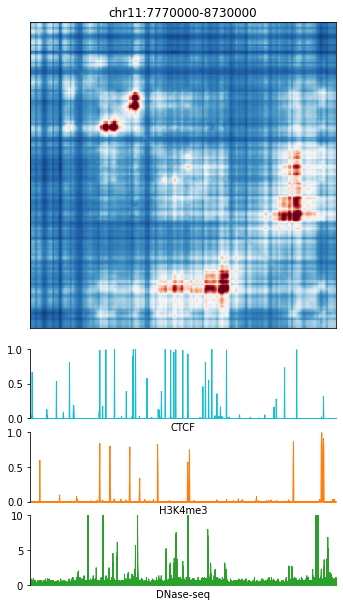

In [ ]:
fig = plt.figure(figsize=(5, 8.5))
gs = GridSpec(7, 5, wspace = 0.75, hspace = 0.2, left = 0.05, top = 0.98, right = 0.9, bottom = 0.05)
ax_hic = fig.add_subplot(gs[:4, :5])
ax_track= [fig.add_subplot(gs[4+i:5+i,:5]) for i in range(3)]
plot_hic(ax_hic,pred_hic_mat,vmin=0,vmax=4)
epis=['CTCF','H3K4me3','DNase-seq']
plot_bindings(ax_track[0],pred_epi[:,0], chrom,start,end)
plot_bindings(ax_track[1],pred_epi[:,-3], chrom,start,end,color='tab:orange')
plot_cage(ax_track[2],stomach_dnase[start:end],chrom,start,end,color='tab:green')
ax_track[2].set_ylim(0,10)
for i in range(len(ax_track)):
  ax_track[i].set_xticks([])
  ax_track[i].set_xlabel(epis[i])
ax_hic.set_title('%s:%s-%s'%(chrom,start+20000,end-20000))
plt.show()

**Example 3: cross-cell type ChIA-pet prediction**

In [ ]:
hic_model_chiapet= build_pretrain_model_hic(hic_args)
hic_model_chiapet.cuda()
hic_model_chiapet.eval()
for m in hic_model.modules():
    if m.__class__.__name__.startswith('BatchNorm'):
        m.train()
hic_model_chiapet.load_state_dict(torch.load('models/GM12878_CTCF_chiapet.pt'))

61


<All keys matched successfully>

In [ ]:
import pickle
with open('hff_dnase.pickle','rb') as f:
    hff_tmp_dnase=pickle.load(f)

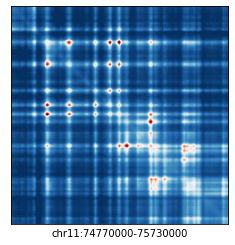

In [ ]:
### the model trained on GM12878 is transferred to HFF cell line
hic_chrom,hic_start,hic_end=['chr11',74750000,75750000]
hff_dnase=hff_tmp_dnase[hic_chrom[3:]].toarray().squeeze()
pred_hic=predict_hic(hic_model_chiapet,hic_chrom,hic_start,hic_end,hff_dnase,fasta_extractor)
pred_hic_mat=complete_mat(arraytouptri(pred_hic.squeeze(),hic_args))

fig,ax=plt.subplots()
plot_hic(ax,pred_hic_mat,vmin=0,vmax=3)
ax.set_xlabel('%s:%s-%s'%(hic_chrom,hic_start+20000,hic_end-20000))
plt.show()

**Example 4: Cross-cell/tissue type Micro-C contact map prediction**

In [ ]:
### load DNase-seq of the two tissues
with open('tibial_nerve_m37_dnase.pickle','rb') as f:
    tbn_tmp_dnase=pickle.load(f)
with open('transverse_colon_m37_dnase.pickle','rb') as f:
    trans_colon_dnase=pickle.load(f)
with open('GM12878_dnase.pickle','rb') as f:
    GM12878_tmp_dnase=pickle.load(f)

In [ ]:
microc_model= build_pretrain_model_microc(microc_args)
microc_model.cuda()
microc_model.load_state_dict(torch.load('models/HFF_microc.pt'))
for m in microc_model.modules():
    if m.__class__.__name__.startswith('BatchNorm'):
        m.train()

61


In [ ]:
### regions of interest
microc_chrom,microc_start,microc_end=['chr11',113000000,113600000]
# microc_chrom,microc_start,microc_end=['chr11',67000000,67600000]
tbn_dnase=tbn_tmp_dnase[int(microc_chrom[3:])].toarray().squeeze()
tc_dnase=trans_colon_dnase[int(microc_chrom[3:])].toarray().squeeze()
stomach_dnase=stomach_tmp_dnase[int(microc_chrom[3:])].toarray().squeeze()
GM12878_dnase=GM12878_tmp_dnase[microc_chrom[3:]].toarray().squeeze()

pred_microc=predict_microc(model=microc_model,
                           chrom=microc_chrom,start=microc_start,end=microc_end,
                           dnase=HUVEC_dnase,
                           fasta_extractor=fasta_extractor)
pred_microc_huvec=complete_mat(arraytouptri(pred_microc.squeeze(),microc_args))

pred_microc=predict_microc(microc_model,microc_chrom,microc_start,microc_end,HCT116_dnase,fasta_extractor)
pred_microc_hct116=complete_mat(arraytouptri(pred_microc.squeeze(),microc_args))

pred_microc=predict_microc(microc_model,microc_chrom,microc_start,microc_end,GM12878_dnase,fasta_extractor)
pred_microc_gm12878=complete_mat(arraytouptri(pred_microc.squeeze(),microc_args))

pred_microc=predict_microc(microc_model,microc_chrom,microc_start,microc_end,HepG2_dnase,fasta_extractor)
pred_microc_hepg2=complete_mat(arraytouptri(pred_microc.squeeze(),microc_args))

pred_microc=predict_microc(microc_model,microc_chrom,microc_start,microc_end,IMR90_dnase,fasta_extractor)
pred_microc_imr90=complete_mat(arraytouptri(pred_microc.squeeze(),microc_args))

pred_microc=predict_microc(microc_model,microc_chrom,microc_start,microc_end,stomach_dnase,fasta_extractor)
pred_microc_stomach=complete_mat(arraytouptri(pred_microc.squeeze(),microc_args))

pred_microc=predict_microc(microc_model,microc_chrom,microc_start,microc_end,tbn_dnase,fasta_extractor)
pred_microc_tbn=complete_mat(arraytouptri(pred_microc.squeeze(),microc_args))

pred_microc=predict_microc(microc_model,microc_chrom,microc_start,microc_end,tc_dnase,fasta_extractor)
pred_microc_tc=complete_mat(arraytouptri(pred_microc.squeeze(),microc_args))

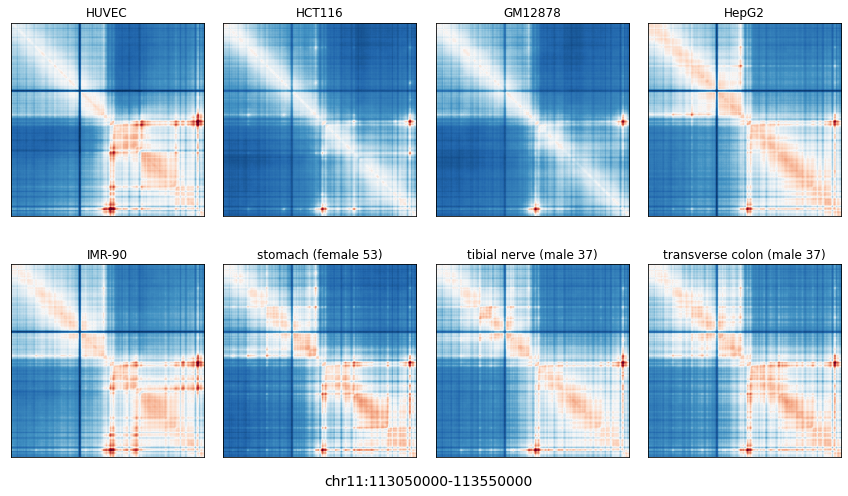

In [ ]:
cells=['HUVEC','HCT116','GM12878','HepG2','IMR-90','stomach (female 53)', 'tibial nerve (male 37)','transverse colon (male 37)']
fig,axs=plt.subplots(2,4,figsize=(12,7))
microc_mat=[pred_microc_huvec,pred_microc_hct116,pred_microc_gm12878,pred_microc_hepg2,pred_microc_imr90,pred_microc_stomach,pred_microc_tbn,pred_microc_tc]
for i in range(2):
    for j in range(4):
        plot_hic(axs[i,j],microc_mat[i*4+j],vmin=-2,vmax=2)
        axs[i,j].set_title(cells[i*4+j])
fig.text(0.5,0.01,'%s:%s-%s'%(microc_chrom,microc_start+50000,microc_end-50000),fontsize=14,ha='center')
plt.tight_layout()
plt.show()

### the predicted Micro-C of HCT116 and GM12878 is not in the same scale with other cell/tissue types, so the scale needs to be adjusted in visualization

## Investigating TF impacts to enhancer activity
The section demonstrates how to analyze contributions of TFs to enhancer activity prediction. An example in A549 cell line is provided.

In [ ]:
!gdown 1b2HDI7WAJf7r_qzGOk-Vbnt4nREEnD03 --output dnase_A549.pickle

Downloading...
From: https://drive.google.com/uc?id=1b2HDI7WAJf7r_qzGOk-Vbnt4nREEnD03
To: /content/dnase_A549.pickle
100% 1.02G/1.02G [00:11<00:00, 86.4MB/s]


You can replace the input DNase-seq file and labels of enhancers with your own data to perform analysis.

In [ ]:
# load A549 DNase-seq 
import pickle
with open('dnase_A549.pickle','rb') as f:
    A549_dnase=pickle.load(f)

# positive and negative samples in A549
pos_enh=np.genfromtxt('EPCOT/EAP/data/A549_positive.bed',dtype='int')
neg_enh=np.genfromtxt('EPCOT/EAP/data/A549_negative.bed',dtype='int')

In [ ]:
!head -3 'EPCOT/EAP/data/A549_positive.bed'

1	779000	780000
1	943000	944000
1	1013000	1014000


In [ ]:
### select 50 positives and 50 negatives to run an example experiment
samples_pos=pos_enh[:50]
samples_neg=neg_enh[:50]
labels=np.concatenate((np.ones(samples_pos.shape[0]),np.zeros(samples_neg.shape[0])))
samples=np.vstack((samples_pos,samples_neg))

In [ ]:
### prepare inputs to the pre-training model
inputs=[]
for i in range(samples.shape[0]):
    chrom,start,end=samples[i]
    input=generate_input(fasta_extractor,'chr'+str(chrom),start,end,A549_dnase[str(chrom)].toarray().squeeze())
    inputs.append(input)
inputs=np.vstack(inputs)
inputs.shape

(100, 5, 1600)

In [ ]:
### predict epigenomic features 
pred_epis=[]
batch_size=24
for i in np.arange(0,inputs.shape[0],batch_size):
    x=torch.tensor(inputs[i:i+batch_size]).float().to(device)
    with torch.no_grad():
        output=pretrain_model(x)
        pred_epis.append(output.cpu().detach().numpy())
pred_epis=np.vstack(pred_epis)
pred_epis.shape

(100, 245)

Running logistic regression (LR) to investigate the contributions of 236 TFs to enhancer activity prediction, the inputs to the LR model are predicted scores of 236 TFs.

In [ ]:
from sklearn.linear_model import LogisticRegression
pred_tfs=pred_epis[:,:236]
clf = LogisticRegression(random_state=0,penalty='l1',solver='saga',C=0.2,max_iter=10000).fit(pred_tfs, labels)
### weights in logistic regression
clf.coef_

array([[ 0.        ,  0.        ,  0.        ,  0.0670208 ,  0.        ,
        -0.01473076,  0.        ,  0.        ,  0.24710093,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.03937998,  0.        ,  0.        ,  0.        ,
         0.03612131,  0.        ,  0.        , -0.18938054,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.15718873,  0.        ,  0.        ,  0.        ,
         0.04722858,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -0.23978826,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 